# Geospatial Analysis

This notebook serves as a demo to visualize geolocation data on a map using OpenStreetMap API, conduct geospatial analysis on the location data, and explore cluster methods for geolocation data. The goal is to visualize app users' mobility at different timepoint. Business applications include geofencing, personalized mobile messaging and geolocation marketing.


* [Part 1 : Reverse Geocoding via OpenStreetMap API](#part1)
* [Part 2 : Map Visualization of Geolocation data](#part2)
* [Part 3 : Geospatial Analysis](#part3)
* [Part 4 : Clustering Geolocation Data](#part4)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from scipy.spatial import Voronoi

from utils import geomap
from utils_voroni import voronoi_polygons_2d

---
<a id="part1"></a>
## Part 1 : Reverse Geocoding via OpenStreetMap API

First, load the original dataset. The dataset contains 
* gelocation data (`lat`,`lon`)
* datetime info extracted from timestamp (`date`, `time`, `wd`, `d`, `h`)

In [3]:
data = pd.read_csv('data/data.csv') #original data are removed, these are exmaple data only
data.head()

lat         lon        date      time  wd  d  h
0  35.512228  138.774826  2018-01-01  00:08:00   1  1  8
1  35.665531  140.017246  2018-01-01  00:08:15   1  1  8
2  35.772766  140.388869  2018-01-01  00:08:30   1  1  8
3  35.772808  140.389780  2018-01-01  00:08:45   1  1  8
4  22.312371  113.939443  2018-01-01  00:09:00   1  1  9

Next, run `scrapper.py` in the current directory to get the address for each pair of (latitude, longitude).

Reverse geocoding is the process of reverse coding of a point location (latitude, longitude) to
a readable address or place ID/name. To retrieve these information, we use
[OpenStreetMap API](https://wiki.openstreetmap.org/wiki/API) for reverse geocoding in `scrapper.py`.

After running `scrapper.py`, we should have the following dataset with additional columns `geodata`, `country`, `country_code`, `state`, `region`, `county`, `city`, `district`.

In [4]:
df = pd.read_csv('data/geodata.csv') #orginal data are removed, these are exmaple data only
df.head()

lat         lon        date      time  wd  d  h  \
0  35.512228  138.774826  2018-01-01  00:08:00   1  1  8   
1  35.665531  140.017246  2018-01-01  00:08:15   1  1  8   
2  35.772766  140.388869  2018-01-01  00:08:30   1  1  8   
3  35.772808  140.389780  2018-01-01  00:08:45   1  1  8   
4  22.312371  113.939443  2018-01-01  00:09:00   1  1  9   

                                             geodata country country_code  \
0  {'accuracy': 0.001, 'address': '富士河口湖町, 南都留郡, ...      日本           jp   
1  {'accuracy': 0.001, 'address': '東関東自動車道, 習志野市,...      日本           jp   
2  {'accuracy': 0.001, 'address': '成田空港検疫所, 新空港自動...      日本           jp   
3  {'accuracy': 0.001, 'address': '61, 新空港自動車道, 東...      日本           jp   
4  {'accuracy': 0.001, 'address': '東涌 Tung Chung,...      中国           cn   

  state region                county  city  district  
0   山梨県    山梨県                  南都留郡   NaN       NaN  
1   千葉県    千葉県                   NaN  習志野市       NaN  
2   千葉県    千葉県                   NaN   成田市       NaN  
3   千葉県    千葉県                   NaN   成田市       NaN  
4    HK     HK  離島區 Islands District   NaN       NaN

---
<a id="part2"></a>
## Part 2 : Map Visualization of Geolocation Data

To visualize the geolocation data on the map, we use OpenStreetMap API to get the map within the desired bounding box and plot the point locations on the map. For details, See method `geomap()` in `utils.py` for implementation.

In [5]:
df = pd.read_csv('data/real_geodata.csv')

OSM map file location:  map/map_zoom11.png


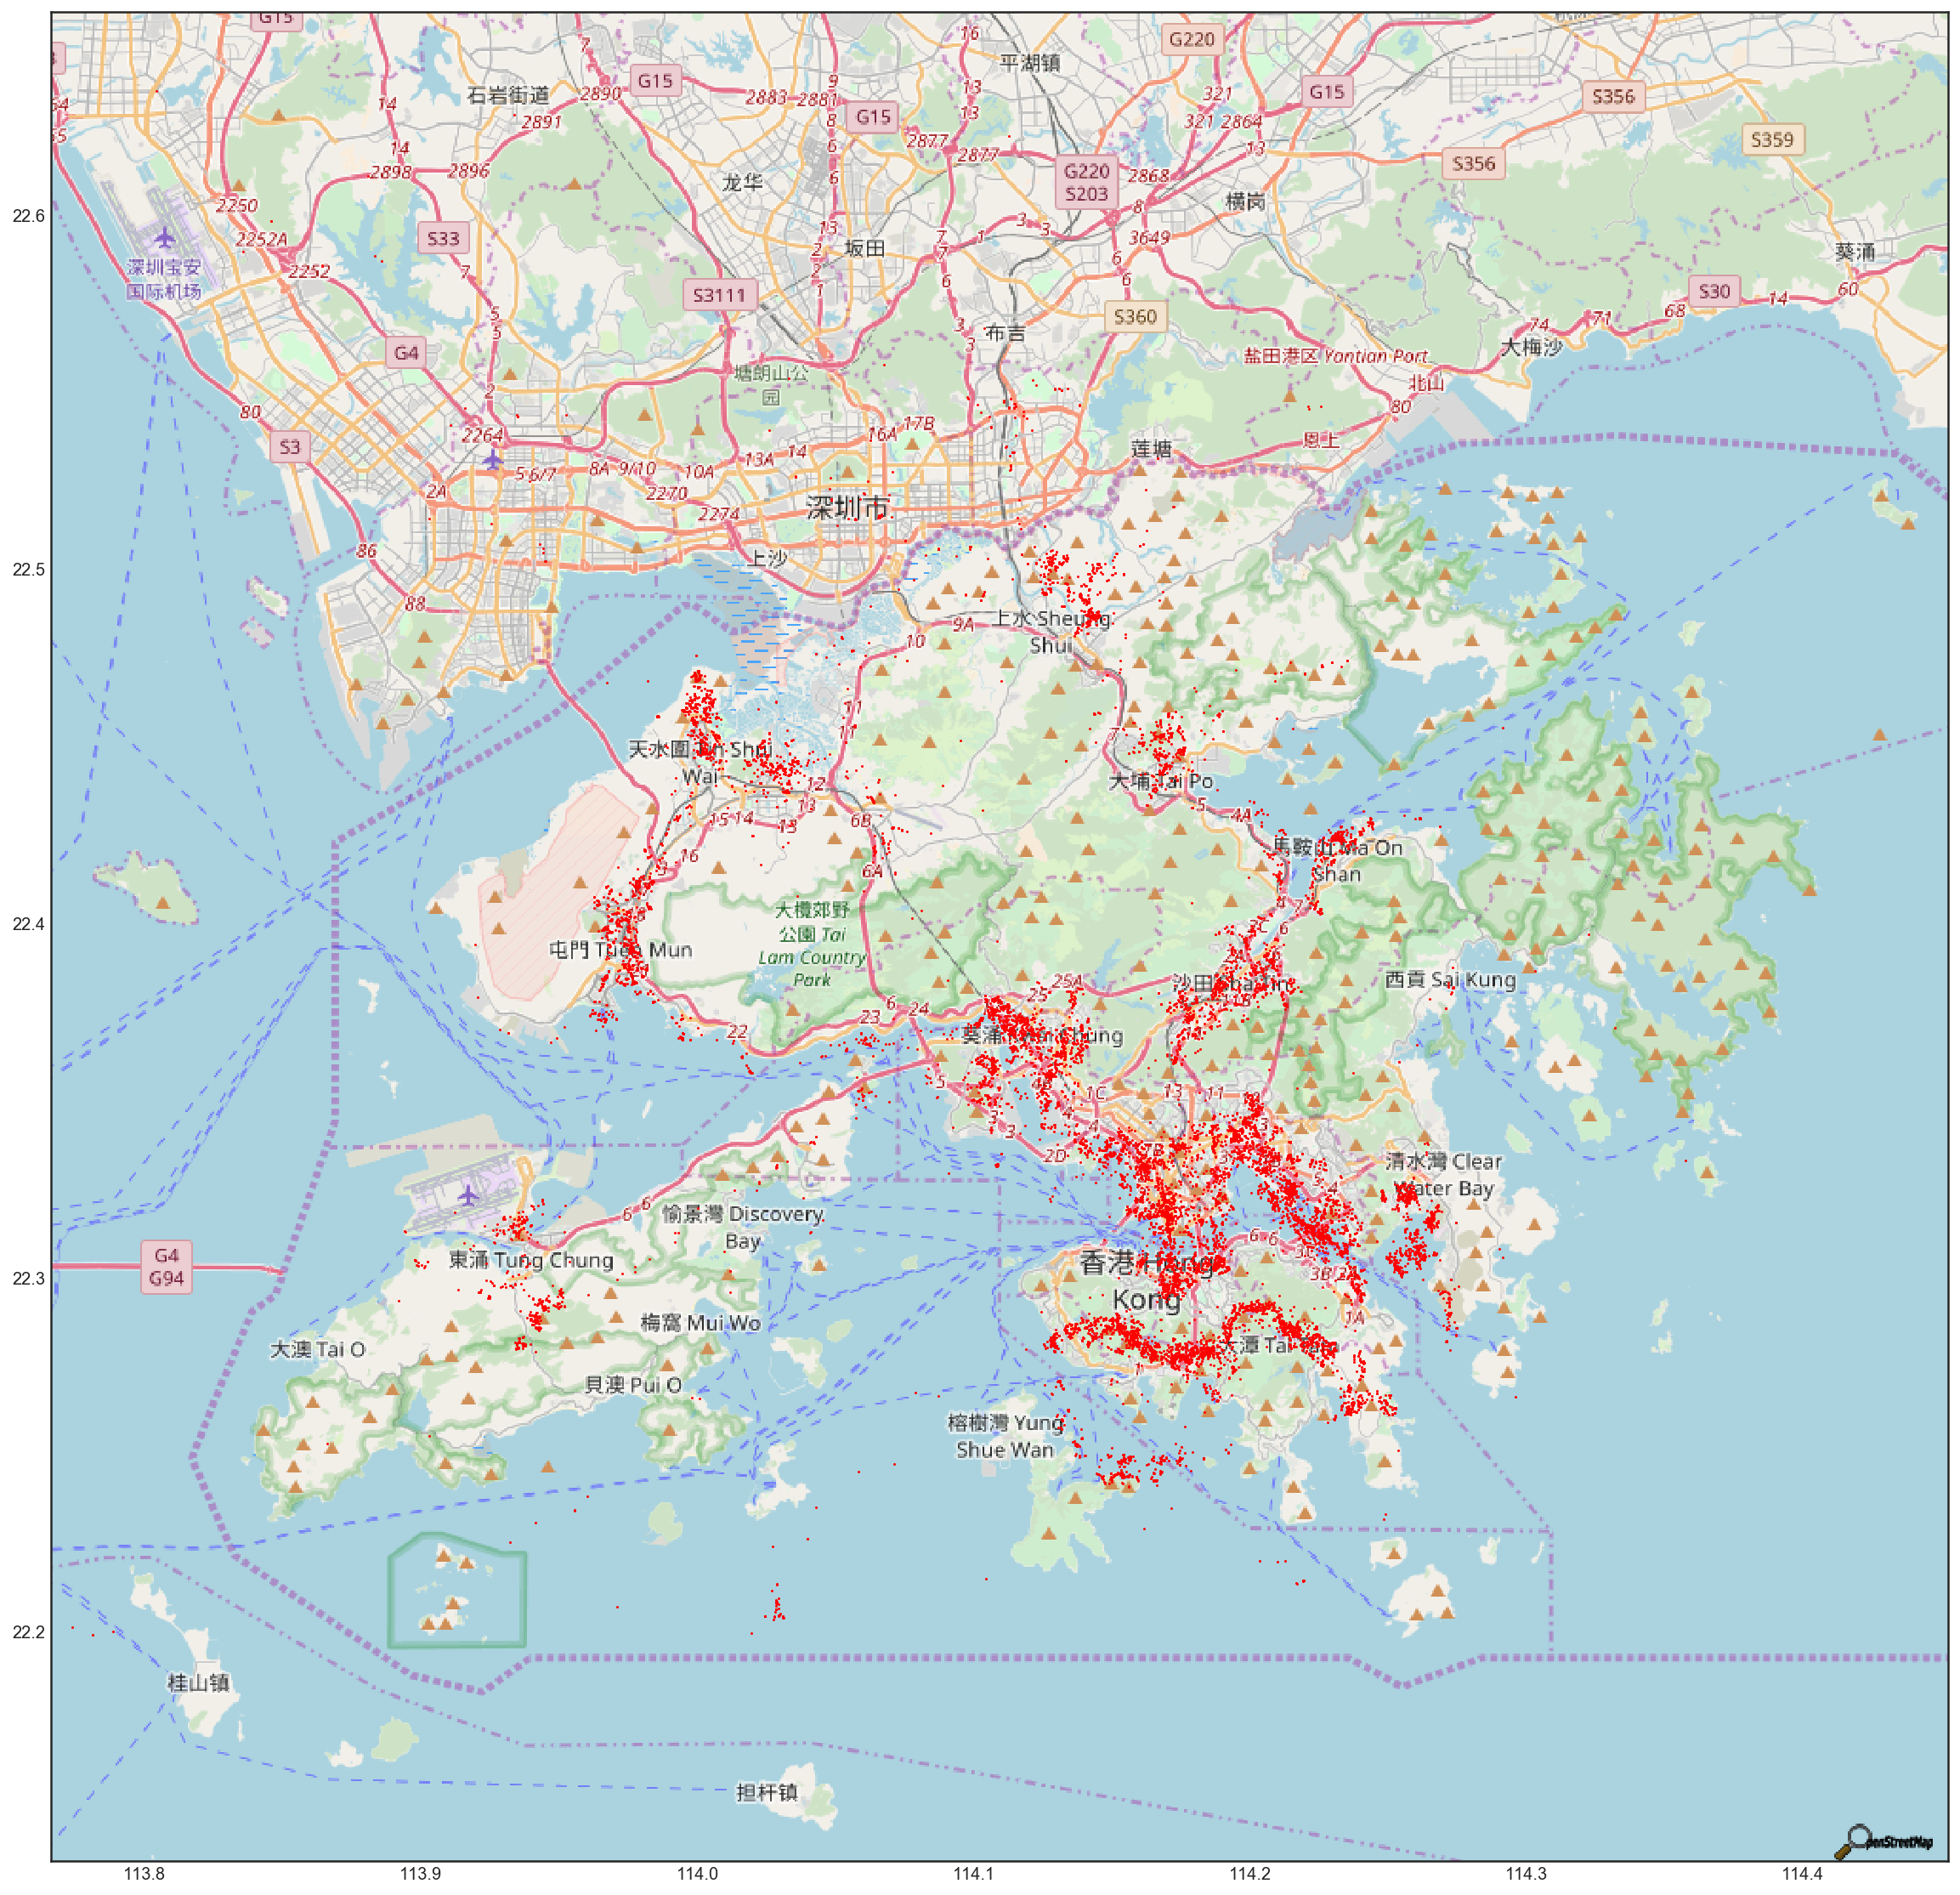

In [6]:
# plot location data in Hong Kong bounding box
plt.style.use('seaborn-white')
fig = plt.figure()
fig.set_size_inches(20,20)
geomap(df[['lon','lat']])
plt.savefig('plot/hkmap.png')
plt.show()

Some of the location data are in fact outside Hong Kong. Let us visualize all the location data on the global map. To do so, we call `geomap()` with customized parameter values to plot the data on the global map. 

OSM map file location:  map/map_zoom2.png


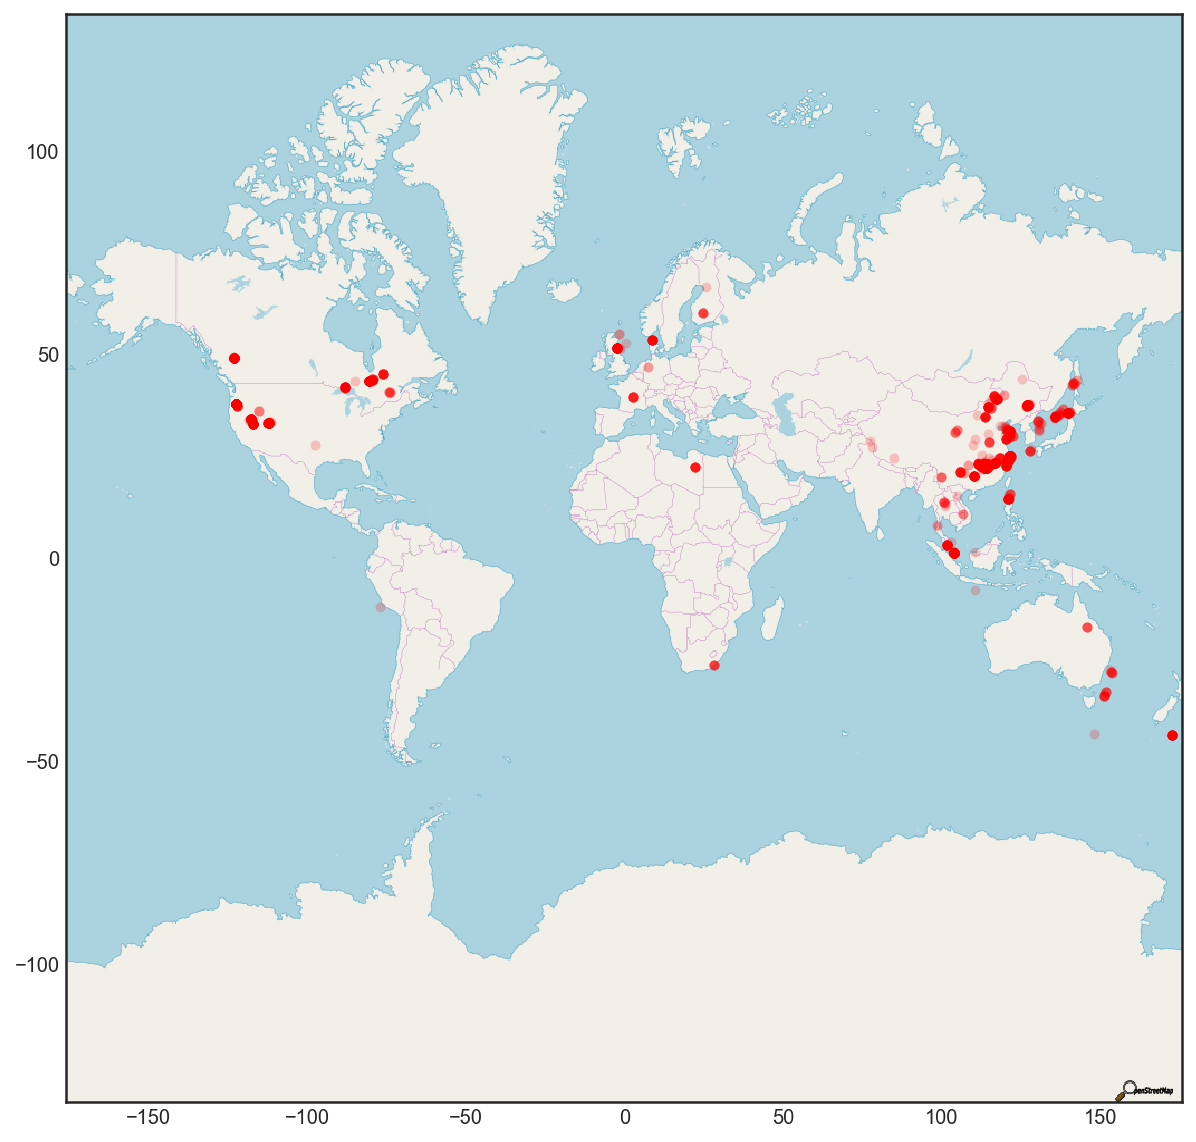

In [7]:
# plot location data in global map
fig = plt.figure()
fig.set_size_inches(10,10)
geomap(df[['lon','lat']], zoom=2, point_size=10, point_alpha=0.2, y=0, x=0)
plt.savefig('plot/globalmap.png')
plt.show()

---
<a id="part3"></a>
## Part 3 : Geospatial Analysis

First, let us see the daily app usage by country. Top 3 locations of app usage are China, US and Taiwan.

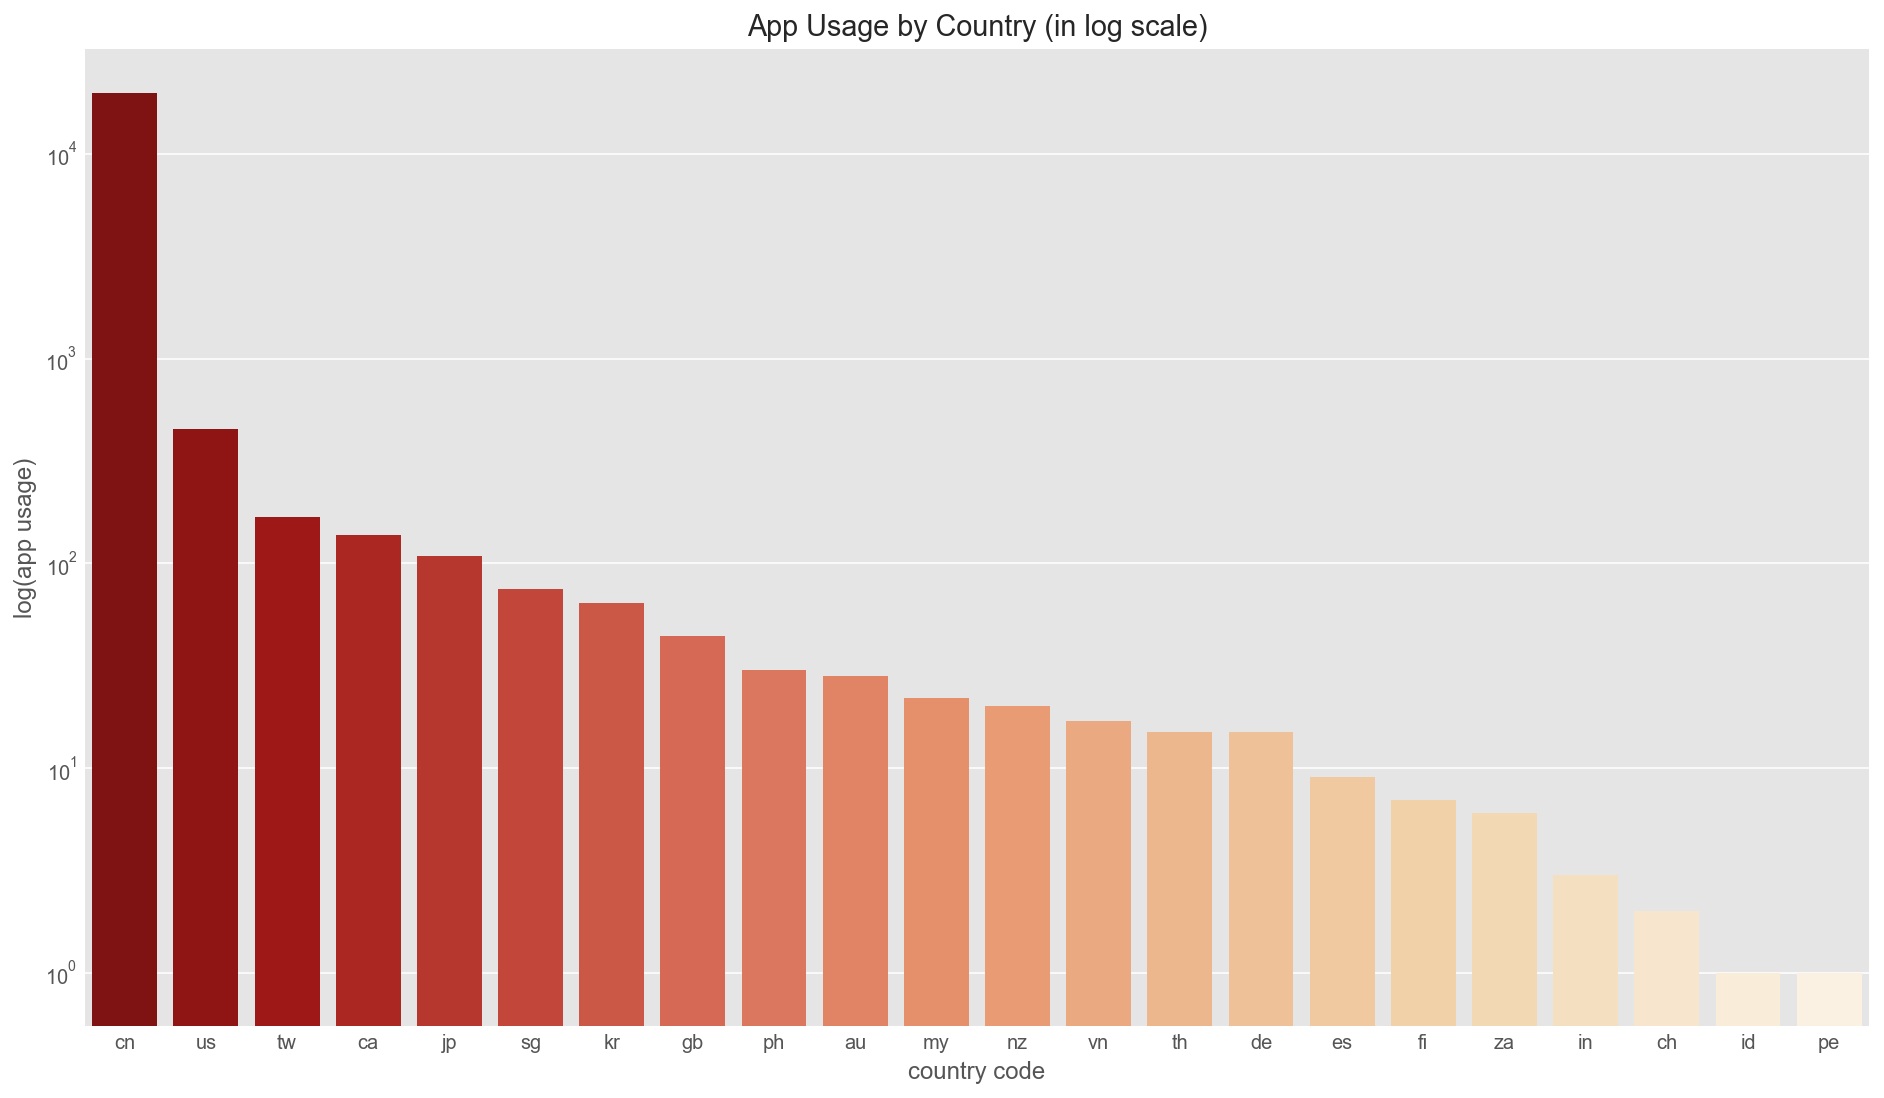

In [8]:
# app usage by country
df_country = df.groupby('country_code').size().reset_index(name='count').sort_values(by=['count'], ascending = False).reset_index()

plt.style.use('ggplot')
plt.figure(figsize=(16,9))
plt.gca().set_yscale("log")
plt.title('App Usage by Country (in log scale)')
ax = sns.barplot(x='country_code', y='count', data=df_country, capsize=.2, palette="OrRd_r")
ax.set(xlabel='country code', ylabel='log(app usage)')
plt.savefig('plot/app_usage_country.png')
plt.show()

Next, let us visualize the time series of daily app usage in China. It shows a steady increasing trend. Note that the app only started to get GPS location in the start of the month.

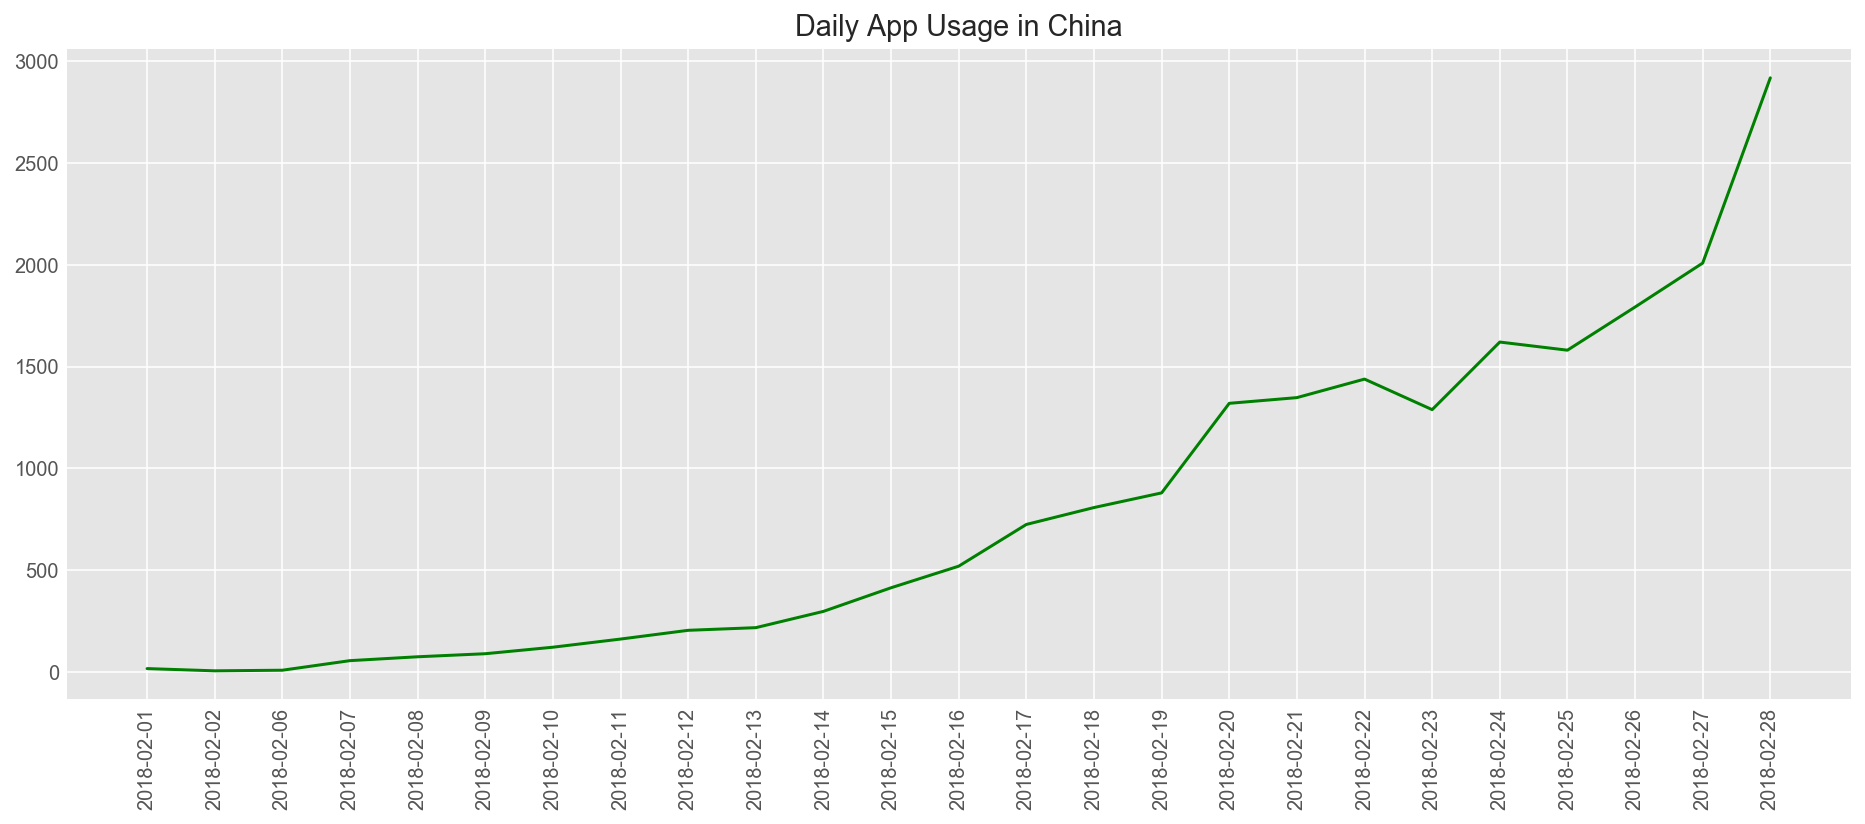

In [9]:
# daily app usage in China
df_cn = df[df.country_code=='cn']

plt.style.use('ggplot')
plt.figure(figsize=(16,6))
plt.xticks(rotation=90)
top = df_cn.groupby('date').size()
plt.plot(top.index, top, 'g-')
plt.title('Daily App Usage in China')
plt.savefig('plot/dau_cn.png')
plt.show()

We can also visualize the distribution of app usage in China during a month, a week or a day.

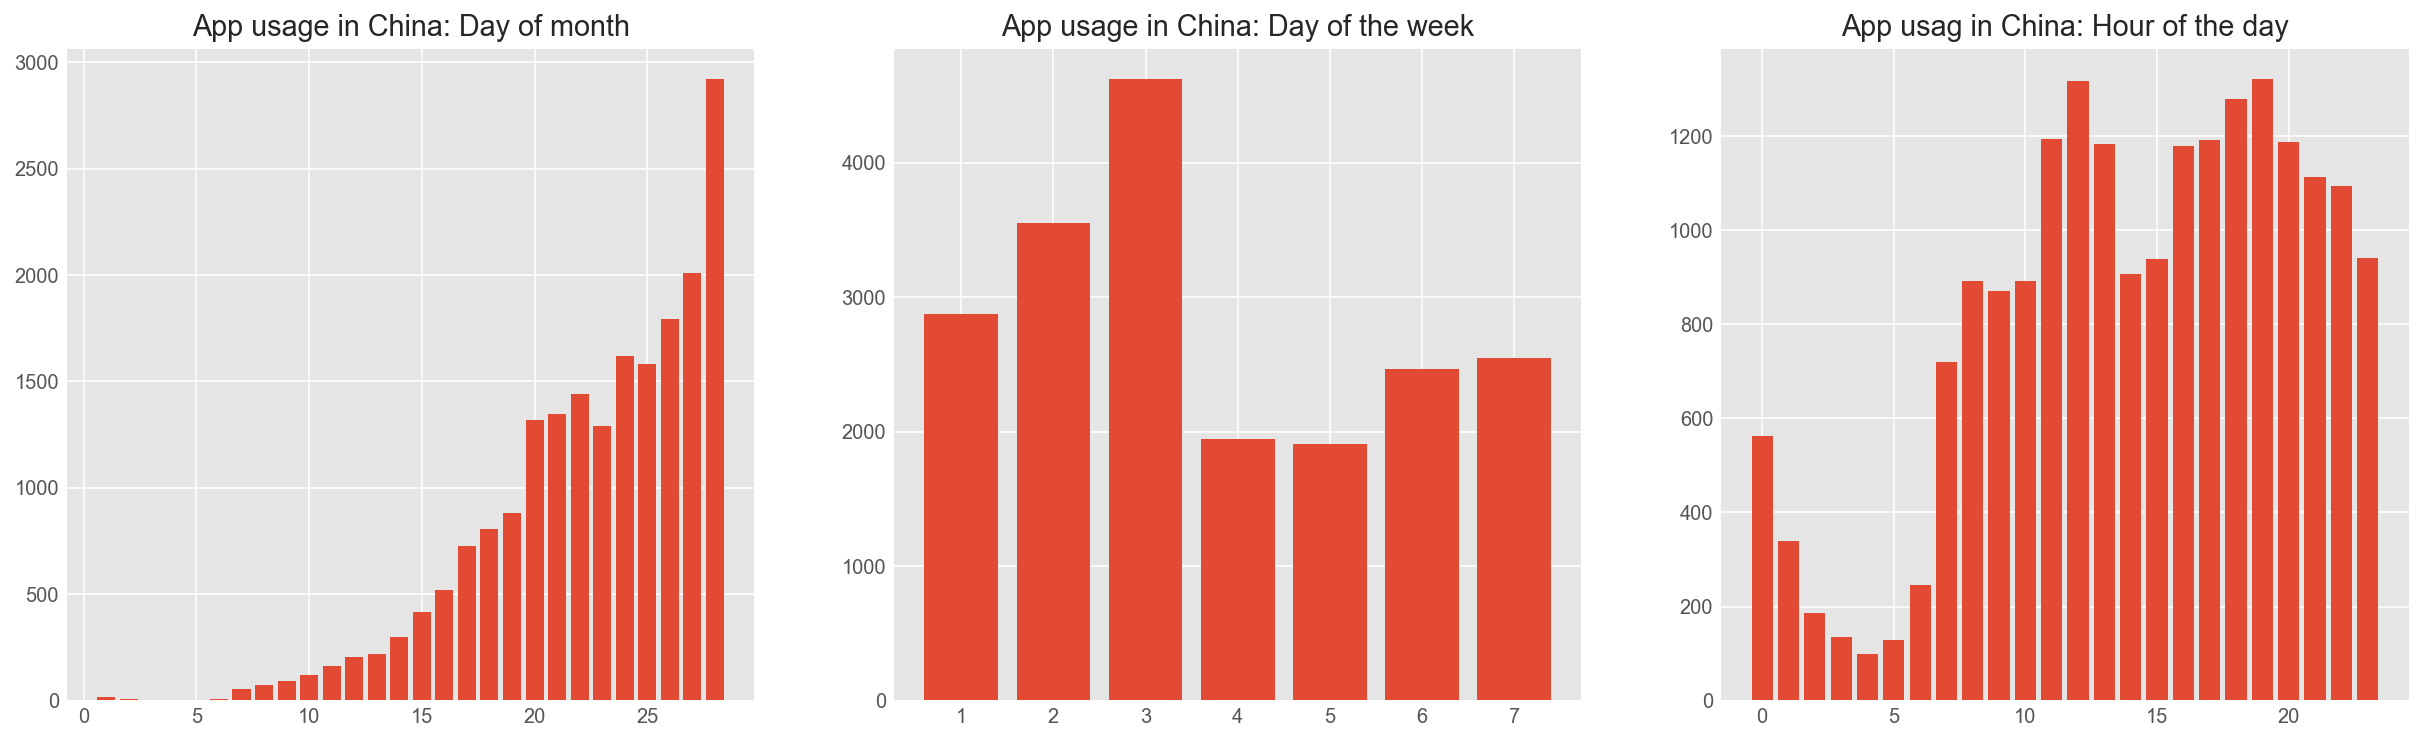

In [10]:
# app usage breakdowns in China
fig = plt.figure()
fig.set_size_inches(21,6)

plt.subplot(1,3,1)
day_of_month = df_cn.groupby('d').size()
plt.bar(day_of_month.index, day_of_month, align='center')
plt.title('App usage in China: Day of month')

plt.subplot(1,3,2)
day_of_week = df_cn.groupby('wd').size()
plt.bar(day_of_week.index, day_of_week, align='center')
plt.title('App usage in China: Day of the week')

plt.subplot(1,3,3)
hour_of_day = df_cn.groupby('h').size()
plt.bar(hour_of_day.index, hour_of_day , align='center')
plt.title('App usag in China: Hour of the day')

plt.savefig('plot/app_usage_cn_breakdown.png')
plt.show()

---
<a id="part4"></a>
## Part 4 : Clustering Geolocation Data

If we filter
In mathematics, a Voronoi diagram is a partitioning of a plane into regions based on distance to points in a specific subset of the plane.

OSM map file location:  map/map_zoom11.png


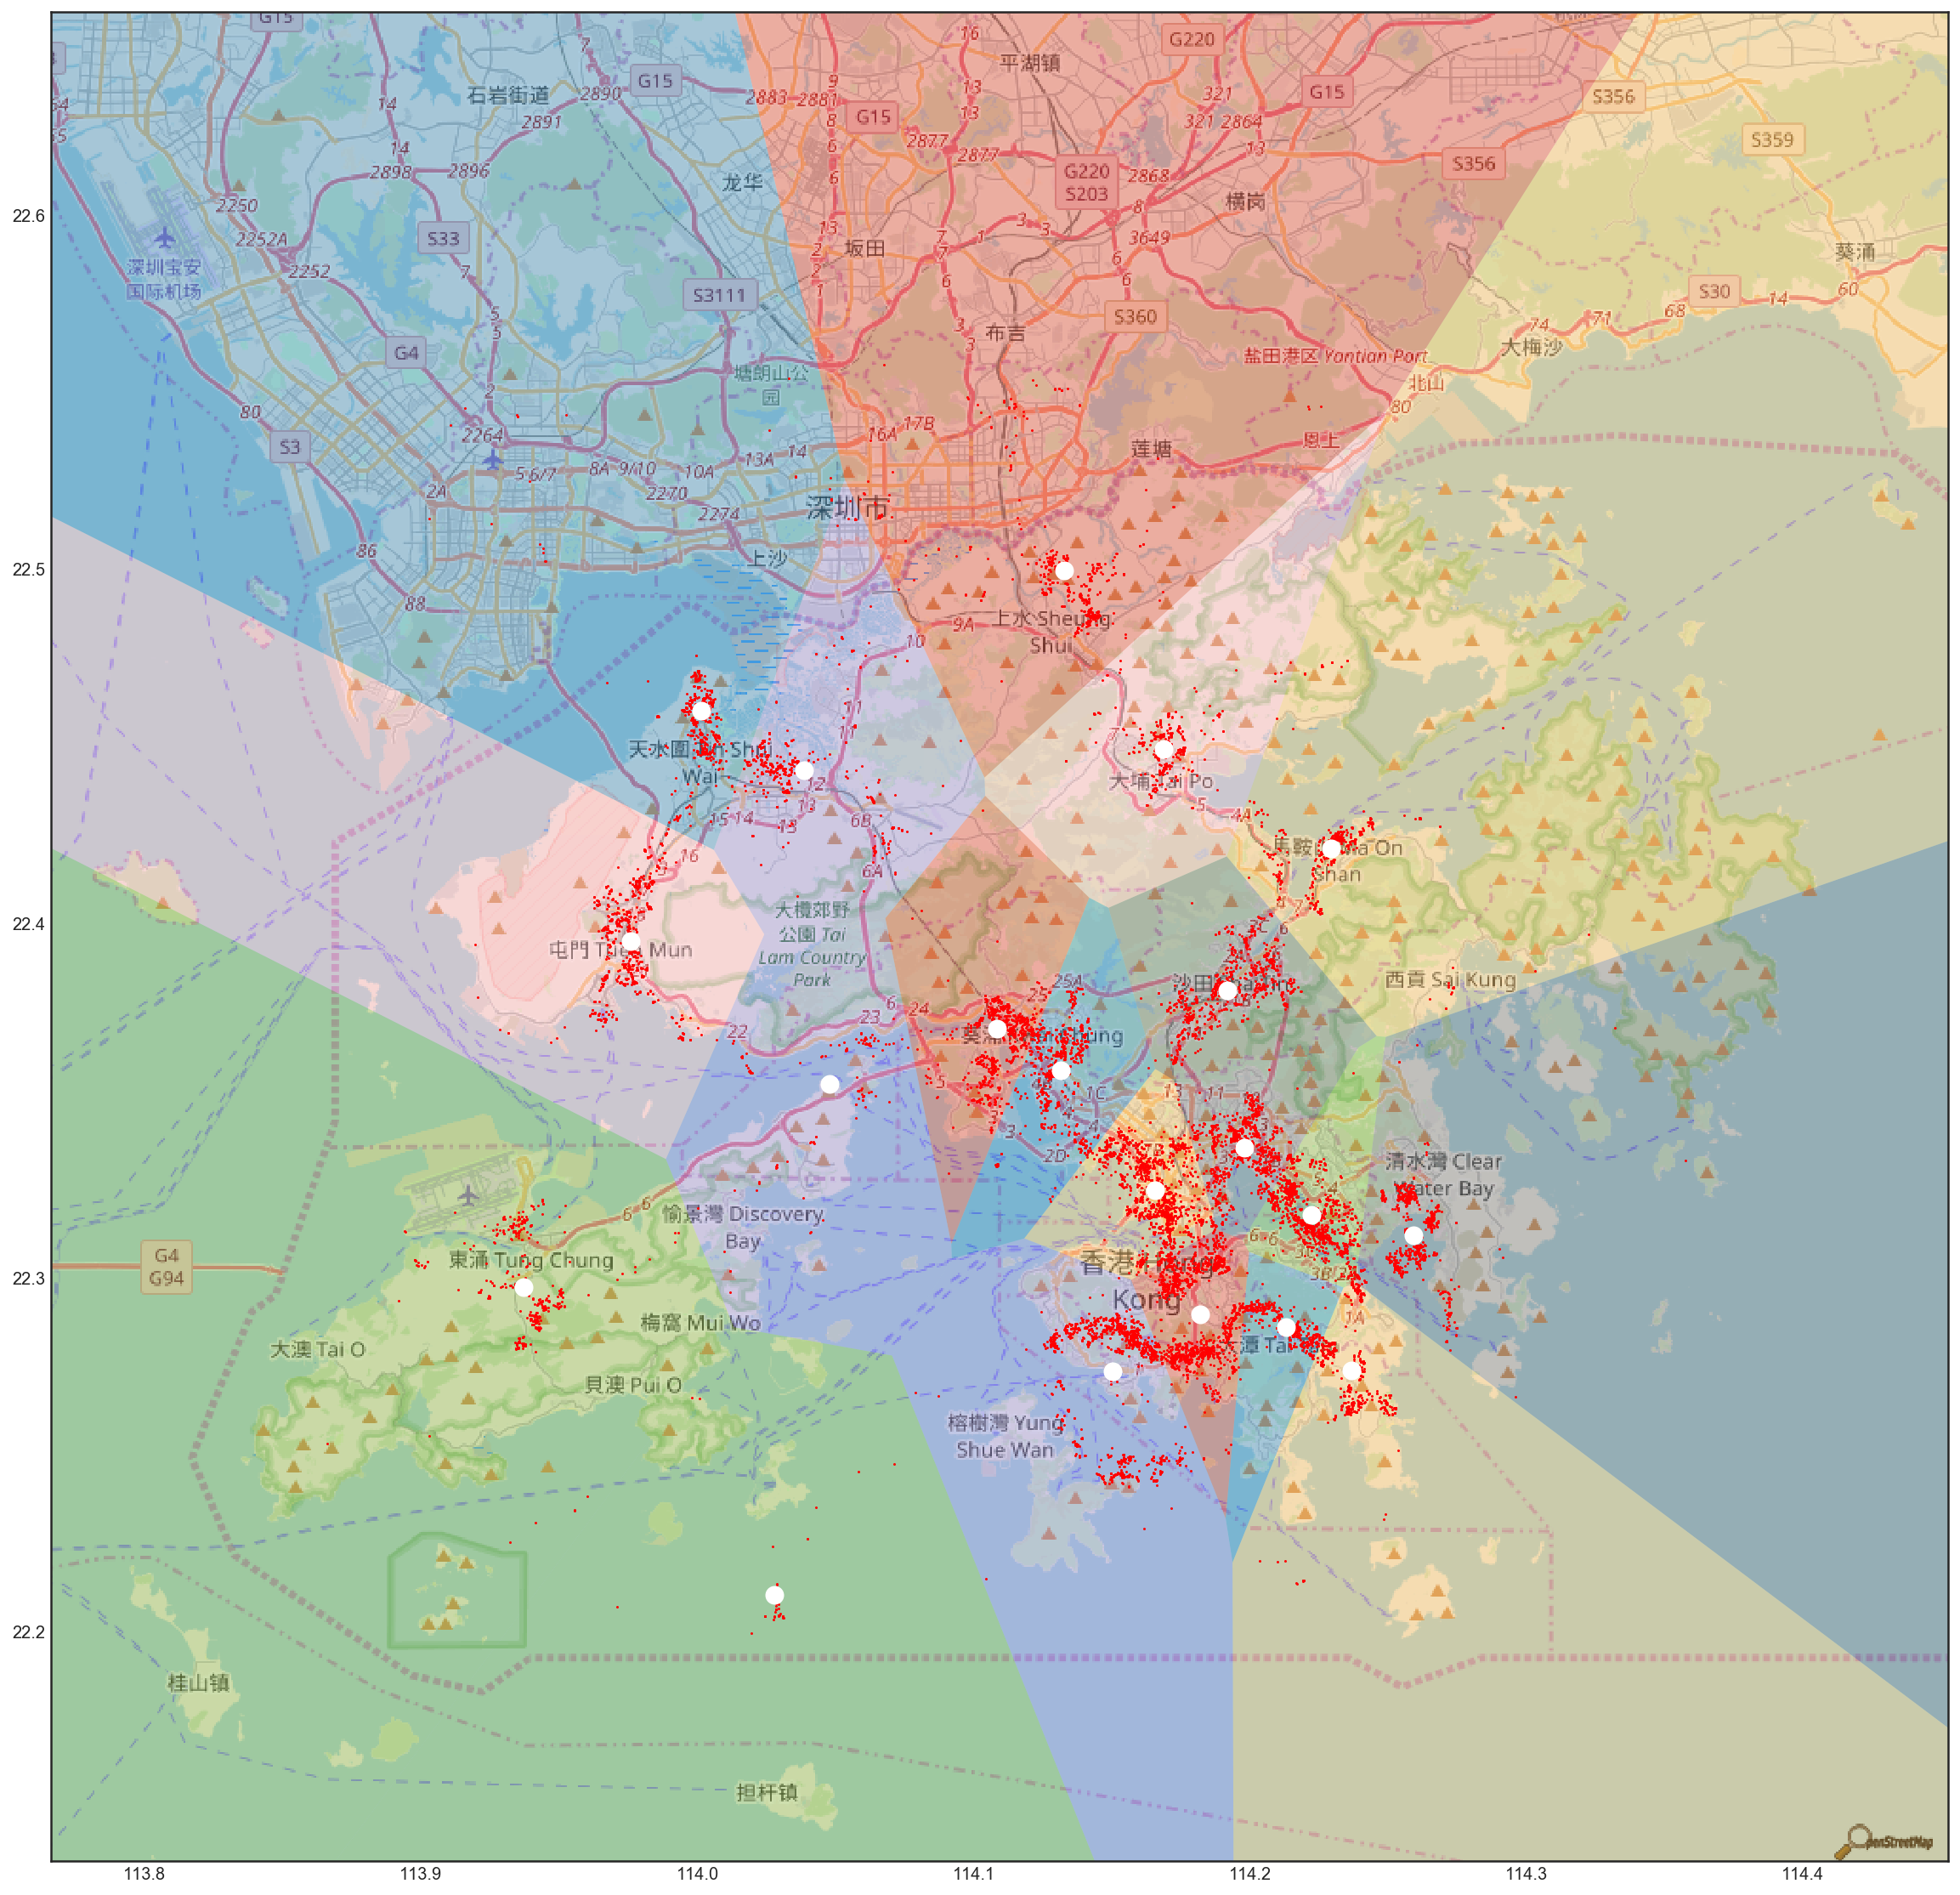

In [23]:
# filter location data to hong kong bounding box
lon_min, lat_min, lon_max, lat_max = 113.8351, 22.1535, 114.4418, 22.5620 #hong kong bounding box
df_hk = df[(df['lon']>lon_min) & (df['lon']<lon_max) & (df['lat']>lat_min) & (df['lat']<lat_max)]

# kmeans clustering
n_clusters = 20
kmean = KMeans(n_clusters)
kmean.fit(df_hk[['lon', 'lat']])
# df_hk['cluster'] = kmean.predict(df_hk[['lon','lat']])

# visualize clusters with Voronoi diagram
points = kmean.cluster_centers_ 
vor = Voronoi(points)
regions, vertices = voronoi_polygons_2d(vor)

plt.style.use('seaborn-white')
fig = plt.figure()
fig.set_size_inches(20,20)
geomap(df_hk[['lon','lat']])
plt.plot(points[:,0], points[:,1], 'wo', markersize=10)

for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.4)

plt.savefig('plot/kmeans_{0}clusters.png'.format(n_clusters))